In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/My Drive/Fraud_Capstone'

In [3]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [4]:
!ls

fraudTest.csv  fraudTrain.csv  kaggle.json


In [5]:
!kaggle datasets download -d kartik2112/fraud-detection

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /content/gdrive/My Drive/Fraud_Capstone. Or use the environment method.


In [6]:
!unzip \*.zip && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go 
from scipy.stats import boxcox
pd.options.display.max_columns = 500
pd.options.display.max_rows = 122
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
seed =45
import warnings
warnings.filterwarnings('ignore')

In [8]:
#Reading two data sets and coverting them into single data frame

Train_data = pd.read_csv("/content/gdrive/My Drive/Kaggle/fraudTrain.csv")
Train_data = Train_data.drop(Train_data.columns[0], axis=1)

Test_data= pd.read_csv("/content/gdrive/My Drive/Kaggle/fraudTest.csv")
Test_data = Test_data.drop(Test_data.columns[0], axis=1)

Fraud = pd.concat([Train_data,Test_data])
Fraud.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [9]:
Fraud.shape

(1852394, 22)

In [10]:
Fraud.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03
std,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00
25%,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00
50%,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00
75%,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00
max,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00


**Understanding Data**


In [11]:
Fraud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
dtypes: float64(5), int6

In [12]:
Fraud.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [13]:
Fraud['is_fraud'].value_counts()

0    1842743
1       9651
Name: is_fraud, dtype: int64

In [14]:
#Finiding unique values in each column
Fraud.nunique()

trans_date_trans_time    1819551
cc_num                       999
merchant                     693
category                      14
amt                        60616
first                        355
last                         486
gender                         2
street                       999
city                         906
state                         51
zip                          985
lat                          983
long                         983
city_pop                     891
job                          497
dob                          984
trans_num                1852394
unix_time                1819583
merch_lat                1754157
merch_long               1809753
is_fraud                       2
dtype: int64

In [15]:
Fraud.job.value_counts(normalize=True,ascending=False)

Film/video editor                 0.007503
Exhibition designer               0.007108
Surveyor, land/geomatics          0.006713
Naval architect                   0.006712
Materials engineer                0.006322
                                    ...   
Armed forces technical officer    0.000004
Veterinary surgeon                0.000004
Contracting civil engineer        0.000004
Warehouse manager                 0.000004
Ship broker                       0.000004
Name: job, Length: 497, dtype: float64

In [16]:
Fraud.merchant.value_counts(normalize=True,ascending=False)

fraud_Kilback LLC                        0.003380
fraud_Cormier LLC                        0.002832
fraud_Schumm PLC                         0.002804
fraud_Kuhn LLC                           0.002716
fraud_Boyer PLC                          0.002699
                                           ...   
fraud_Douglas, DuBuque and McKenzie      0.000594
fraud_Treutel-King                       0.000593
fraud_Satterfield-Lowe                   0.000591
fraud_Hahn, Douglas and Schowalter       0.000589
fraud_Ritchie, Bradtke and Stiedemann    0.000588
Name: merchant, Length: 693, dtype: float64

In [17]:
#Converting data type of trans_date_trans_time to datetime
Fraud['trans_date_trans_time'] = pd.to_datetime(Fraud['trans_date_trans_time'])
Fraud.dtypes['trans_date_trans_time']

dtype('<M8[ns]')

In [18]:
#Transaction Hour from 'trans_date_trans_time' 
Fraud['trans_hour'] = Fraud['trans_date_trans_time'].dt.hour
#Weekday' from trans_date_trans_time' 
Fraud['Weekday'] = Fraud['trans_date_trans_time'].dt.day_name()
#'Year Month' Feature from trans_date_trans_time' Feature
Fraud['year_month'] = Fraud['trans_date_trans_time'].dt.to_period('M')
Fraud_time  = Fraud
Fraud.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour,Weekday,year_month
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,Tuesday,2019-01
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,Tuesday,2019-01
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,Tuesday,2019-01
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,Tuesday,2019-01
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,Tuesday,2019-01


In [19]:
# Age of the Customer
#Age of Customer = Trasaction Date - DOB
Fraud['dob'] = pd.to_datetime(Fraud['dob'])
Fraud['Age'] = np.round((Fraud['trans_date_trans_time'] - Fraud['dob'])/np.timedelta64(1,'Y'))
Fraud['Age']

0         31.0
1         41.0
2         57.0
3         52.0
4         33.0
          ... 
555714    55.0
555715    21.0
555716    39.0
555717    55.0
555718    28.0
Name: Age, Length: 1852394, dtype: float64

In [20]:
# Distribution of  Amount column (amt)
pd.concat(
[Fraud['amt'].describe(percentiles = [0.5,0.95,0.999])\
.reset_index().rename(columns={'index': 'Row Type', 'amt':'Amount Distribution'}),
Fraud.loc[Fraud['is_fraud']==0,['amt']].describe(percentiles = [0.5,0.95,0.999])\
.reset_index(drop = 1).rename(columns={'amt':'Non Fraudulent Amount '}),
Fraud.loc[Fraud['is_fraud']==1,['amt']].describe(percentiles = [0.5,0.95,0.999])\
.reset_index(drop = 1).rename(columns={'amt':'Fraudulent Amount '})],
axis=1)
# Mean of Fraudulent Transaction is higher than non-Fraudulent transaction
#Mean of Non Fraud Transactions: 6.76
#Mean of Fraud Transactions: 530.66

,Row Type,Amount Distribution,Non Fraudulent Amount,Fraudulent Amount
0,count,1.852394e+06,1.842743e+06,9651.000000
1,mean,7.006357e+01,6.765128e+01,530.661412
2,std,1.592540e+02,1.535481e+02,391.028873
3,min,1.000000e+00,1.000000e+00,1.060000
4,50%,4.745000e+01,4.724000e+01,390.000000
5,95%,1.953400e+02,1.895900e+02,1084.090000
6,99.9%,1.517241e+03,1.519623e+03,1293.127000
7,max,2.894890e+04,2.894890e+04,1376.040000


In [21]:
# Calculating the distance between longitude and latitude 
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [22]:
Fraud['Distance'] = \
    haversine(Fraud['lat'], Fraud['long'],
                 Fraud['merch_lat'], Fraud['merch_long'])
Fraud['Distance'].describe()

count    1.852394e+06
mean     7.611173e+01
std      2.911697e+01
min      2.225452e-02
25%      5.532009e+01
50%      7.821638e+01
75%      9.850947e+01
max      1.521172e+02
Name: Distance, dtype: float64

In [23]:
# Mercant column in percentage
merchant = Fraud[['merchant','trans_num']].groupby(['merchant']).count().reset_index()
merchant.columns = ['Merchant','merchant_count']

merchant['percent'] = (merchant['merchant_count']/merchant['merchant_count'].sum())*100

merchant.sort_values(by = ['percent'], ascending=False)

,Merchant,merchant_count,percent
316,fraud_Kilback LLC,6262,0.338049
105,fraud_Cormier LLC,5246,0.283201
571,fraud_Schumm PLC,5195,0.280448
349,fraud_Kuhn LLC,5031,0.271594
70,fraud_Boyer PLC,4999,0.269867
...,...,...,...
143,"fraud_Douglas, DuBuque and McKenzie",1101,0.059437
633,fraud_Treutel-King,1098,0.059275
544,fraud_Satterfield-Lowe,1095,0.059113
221,"fraud_Hahn, Douglas and Schowalter",1091,0.058897


In [24]:
merchant.describe()

,merchant_count,percent
count,693.000000,693.000000
mean,2673.007215,0.144300
std,819.238141,0.044226
min,1090.000000,0.058843
25%,2295.000000,0.123894
50%,2663.000000,0.143760
75%,3346.000000,0.180631
max,6262.000000,0.338049


In [25]:
#Job column in percentage 
Job = Fraud[['job','trans_num']].groupby(['job']).count().reset_index()
Job.columns = ['Job','tran_count_by_job']

Job['percent'] = (Job['tran_count_by_job']/Job['tran_count_by_job'].sum())*100

Job.sort_values(by = ['percent'], ascending=False)

,Job,tran_count_by_job,percent
194,Film/video editor,13898,0.750272
188,Exhibition designer,13167,0.710810
442,"Surveyor, land/geomatics",12436,0.671347
309,Naval architect,12434,0.671239
287,Materials engineer,11711,0.632209
...,...,...,...
175,"Engineer, water",8,0.000432
485,Veterinary surgeon,8,0.000432
490,Warehouse manager,7,0.000378
423,Ship broker,7,0.000378


In [26]:
fraud_job = Fraud[['job','is_fraud','trans_num']].groupby(['job','is_fraud']).count().reset_index()
fraud_job.columns = ['Job','is_fraud','count']

fraud_job =  fraud_job.merge(Job[['Job','tran_count_by_job','percent']],how='inner',\
                                  left_on='Job',right_on='Job')


fraud_job['percent_grp'] = (fraud_job['count']/fraud_job['tran_count_by_job'])*100
plot_job = fraud_job.sort_values(by = ["tran_count_by_job"], ascending = False).head(20)
plot_job

,Job,is_fraud,count,tran_count_by_job,percent,percent_grp
378,Film/video editor,1,52,13898,0.750272,0.374155
377,Film/video editor,0,13846,13898,0.750272,99.625845
366,Exhibition designer,1,51,13167,0.710810,0.387332
365,Exhibition designer,0,13116,13167,0.710810,99.612668
861,"Surveyor, land/geomatics",0,12386,12436,0.671347,99.597941
862,"Surveyor, land/geomatics",1,50,12436,0.671347,0.402059
603,Naval architect,1,66,12434,0.671239,0.530803
602,Naval architect,0,12368,12434,0.671239,99.469197
559,Materials engineer,1,62,11711,0.632209,0.529417
558,Materials engineer,0,11649,11711,0.632209,99.470583


In [27]:
plot_job['label'] = 'Not Fraud'
plot_job.loc[plot_job['is_fraud']==1,['label']]= 'Fraud'
plot_job

,Job,is_fraud,count,tran_count_by_job,percent,percent_grp,label
378,Film/video editor,1,52,13898,0.750272,0.374155,Fraud
377,Film/video editor,0,13846,13898,0.750272,99.625845,Not Fraud
366,Exhibition designer,1,51,13167,0.710810,0.387332,Fraud
365,Exhibition designer,0,13116,13167,0.710810,99.612668,Not Fraud
861,"Surveyor, land/geomatics",0,12386,12436,0.671347,99.597941,Not Fraud
862,"Surveyor, land/geomatics",1,50,12436,0.671347,0.402059,Fraud
603,Naval architect,1,66,12434,0.671239,0.530803,Fraud
602,Naval architect,0,12368,12434,0.671239,99.469197,Not Fraud
559,Materials engineer,1,62,11711,0.632209,0.529417,Fraud
558,Materials engineer,0,11649,11711,0.632209,99.470583,Not Fraud


# **Exploratory data analytics (EDA)**

In [28]:
# Percentage of Fraud and non fraud 
classes=Fraud['is_fraud'].value_counts()
normal_share=classes[0]/Fraud['is_fraud'].count()*100
fraud_share=classes[1]/Fraud['is_fraud'].count()*100

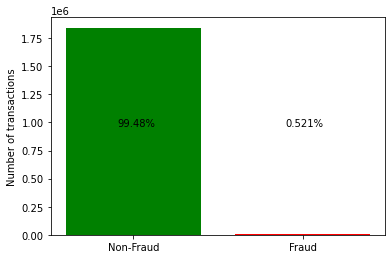

In [29]:
plt.bar(['Non-Fraud','Fraud'], classes, color=['g','r'])
plt.ylabel('Number of transactions')
plt.annotate("{0:.4}%".format(normal_share),(0.2, 0.5), xycoords='axes fraction')
plt.annotate("{0:.4}%".format(fraud_share),(0.7, 0.5), xycoords='axes fraction')
plt.show()
# As per plot we can see it is highly imbalanced 

In [30]:
pe_grp = plot_job['Job'].unique()
print(pe_grp)

pm_grp = plot_job['label'].unique()
print(pm_grp)

['Film/video editor' 'Exhibition designer' 'Surveyor, land/geomatics'
 'Naval architect' 'Materials engineer' 'Designer, ceramics/pottery'
 'Environmental consultant' 'Financial adviser' 'Systems developer'
 'IT trainer']
['Fraud' 'Not Fraud']


In [31]:
# Plot percentage list of fraud according to  job 
figure = go.Figure(data=[
    go.Bar(name=pm_grp[0], x = pe_grp, y = plot_job[plot_job['label'] == pm_grp[0]]['percent_grp']),
    
])

figure.update_layout(xaxis_title="Job Group "\
                  ,yaxis_title="Fraud Percentange of Listings")
figure.show()
#Navalarchitect and Materials engineer has the highest percentage of fraud transactions

In [32]:
Fraud.skew()

cc_num         2.851074
amt           40.812809
zip            0.078950
lat           -0.191999
long          -1.146919
city_pop       5.590805
unix_time     -0.019736
merch_lat     -0.188097
merch_long    -1.143933
is_fraud      13.745675
trans_hour    -0.283419
Age            0.609580
Distance      -0.235677
dtype: float64

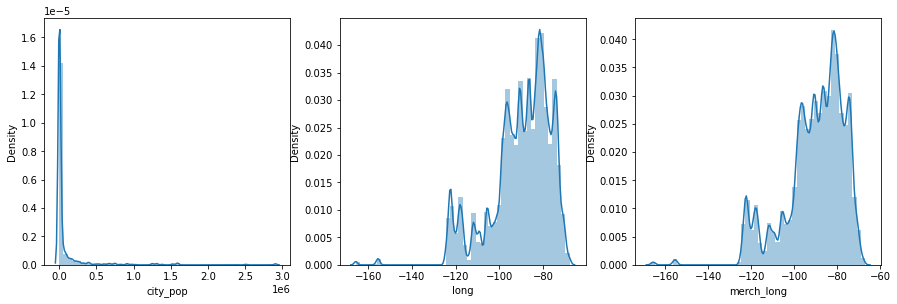

In [33]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
sns.distplot(Fraud['city_pop'])
plt.subplot(2,3,2)
sns.distplot(Fraud['long'])
plt.subplot(2,3,3)
sns.distplot(Fraud['merch_long'])


plt.show()

In [34]:
skw = Fraud[['long','merch_long','city_pop']].skew()
skw = skw[abs(skw)>.75].index

In [35]:
from sklearn.preprocessing import PowerTransformer
Fraud[skw] = PowerTransformer().fit_transform(Fraud[skw])

In [36]:
Fraud.skew()

cc_num         2.851074
amt           40.812809
zip            0.078950
lat           -0.191999
long          -0.062381
city_pop       0.058579
unix_time     -0.019736
merch_lat     -0.188097
merch_long    -0.061164
is_fraud      13.745675
trans_hour    -0.283419
Age            0.609580
Distance      -0.235677
dtype: float64

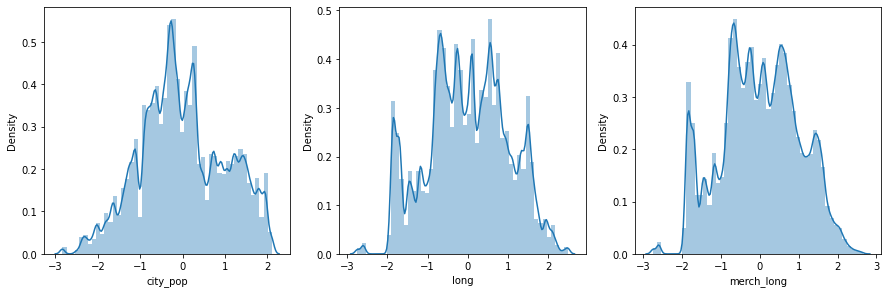

In [37]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
sns.distplot(Fraud['city_pop'])
plt.subplot(2,3,2)
sns.distplot(Fraud['long'])
plt.subplot(2,3,3)
sns.distplot(Fraud['merch_long'])


plt.show()

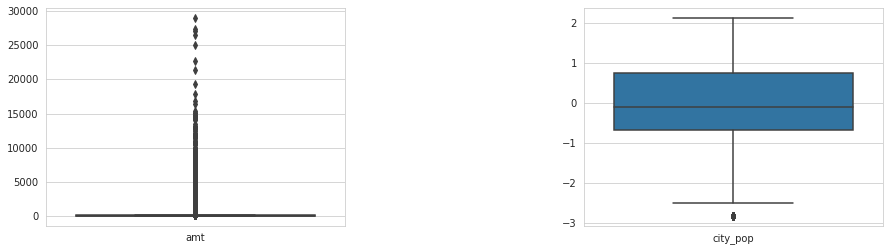

In [38]:
# box plot for amt and city poulation column
sns.set_style('whitegrid')
fig, axes = plt.subplots(1,2,figsize=[15,4])
plt.subplots_adjust(wspace=0.8)
sns.boxplot(data =Fraud[['amt']],ax=axes[0])
sns.boxplot(data =Fraud[['city_pop']],ax=axes[1])
plt.show()

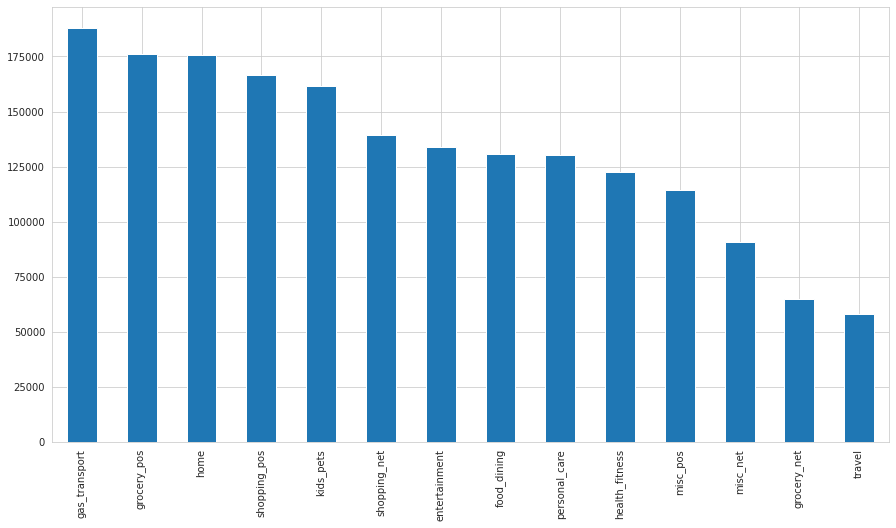

In [39]:
#plot for category column
plt.figure(figsize=(15,8))
Fraud['category'].value_counts().plot.bar()
plt.show()
# gas_transport has  highest number of  credit card transactions

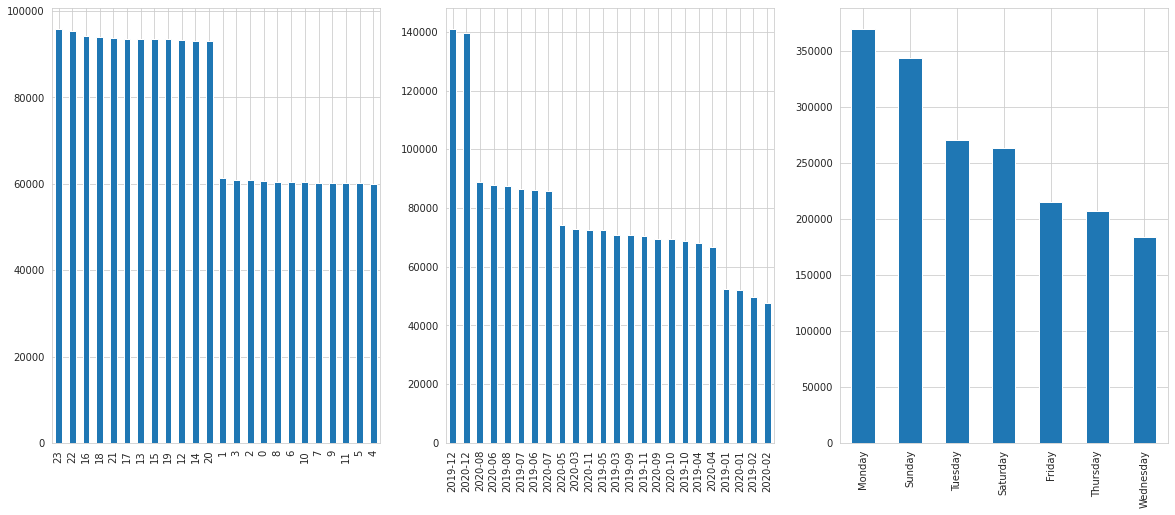

In [40]:
#Plot for timing of the transactions in hours,week and year
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
Fraud['trans_hour'].value_counts().plot.bar();
plt.subplot(1,3,2)
Fraud['year_month'].value_counts().plot.bar();
plt.subplot(1,3,3)
Fraud['Weekday'].value_counts().plot.bar();
plt.show()
#It is found that there is higher fraud risk at night and in the morning
#Monday and Sunday has the highest number of transactions 

In [41]:
Fraud.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'trans_hour', 'Weekday', 'year_month', 'Age',
       'Distance'],
      dtype='object')

In [42]:
#dropping columns as it irrelevent 
Fraud = Fraud.drop(['trans_date_trans_time','first', 'last','zip','trans_num','cc_num','dob','year_month'], axis=1)
Fraud.columns

Index(['merchant', 'category', 'amt', 'gender', 'street', 'city', 'state',
       'lat', 'long', 'city_pop', 'job', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'trans_hour', 'Weekday', 'Age', 'Distance'],
      dtype='object')

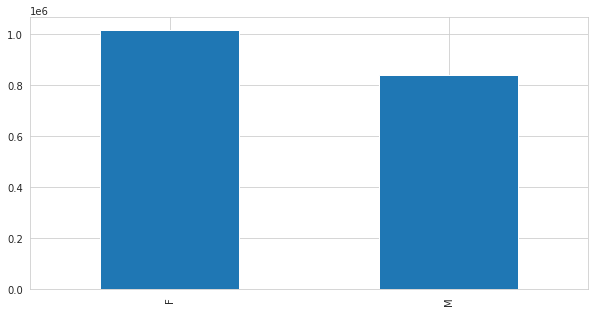

In [43]:
# plot for trasaction on basis of gender
plt.figure(figsize=(10,5))
Fraud['gender'].value_counts().plot.bar();
plt.show()
#Female customers are higher than male customers 

In [44]:
#Creating bins for the AGE column
bins = [0,20,30,40,50,60,70]
slot = ['0-20','20-30','30-40','40-50','50-60','60-70']

AGE_RANGE = pd.cut(Fraud['Age'],bins,labels=slot)
AGE_RANGE.value_counts()

40-50    431809
30-40    415647
20-30    302436
50-60    263934
60-70    192861
0-20      54880
Name: Age, dtype: int64

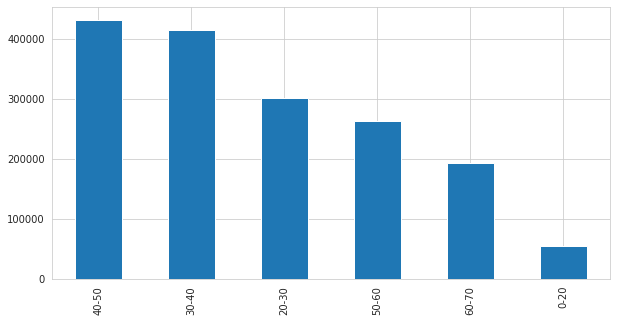

In [45]:
#plot for age of cutomers
plt.figure(figsize=(10,5))
AGE_RANGE.value_counts().plot.bar();
plt.show()
#Age group of 40-50 years has the highest number of transaction

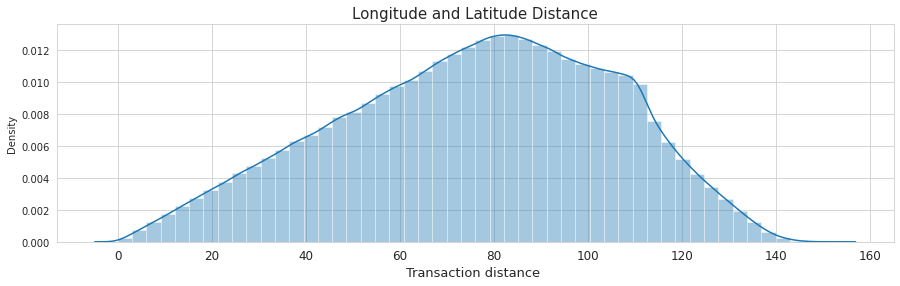

In [46]:
Fraud.Distance.describe()
plt.figure(figsize=(15,4))
sns.distplot(Fraud.Distance)
plt.title('Longitude and Latitude Distance', fontsize=15)
plt.xlabel('Transaction distance ',fontsize=13)
plt.xticks(fontsize=12)
plt.show()

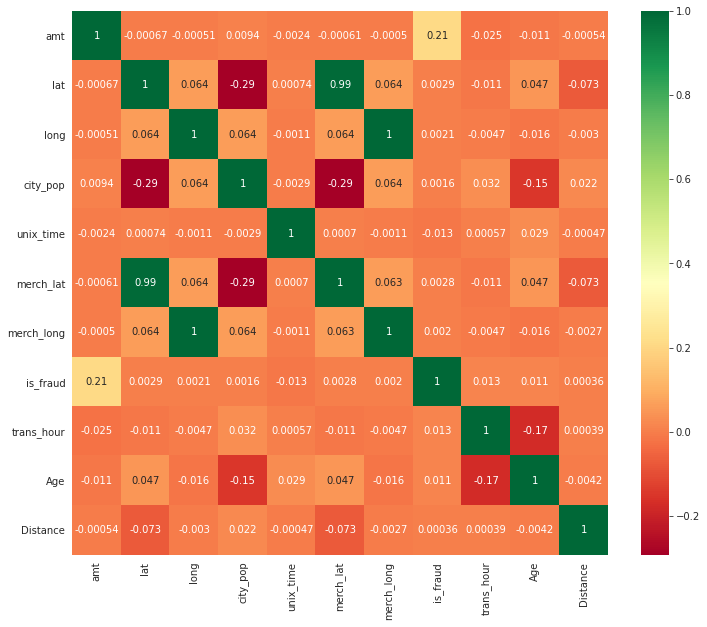

In [47]:
corrmat = Fraud.corr()
plt.figure(figsize=(12,10))
sns.heatmap(Fraud[corrmat.index].corr(),annot=True,cmap="RdYlGn")

In [48]:
#dropping columns to avoid multicollinearity
Fraud = Fraud.drop(['lat','long','merch_lat','trans_hour'], axis=1)
Fraud.columns

Index(['merchant', 'category', 'amt', 'gender', 'street', 'city', 'state',
       'city_pop', 'job', 'unix_time', 'merch_long', 'is_fraud', 'Weekday',
       'Age', 'Distance'],
      dtype='object')

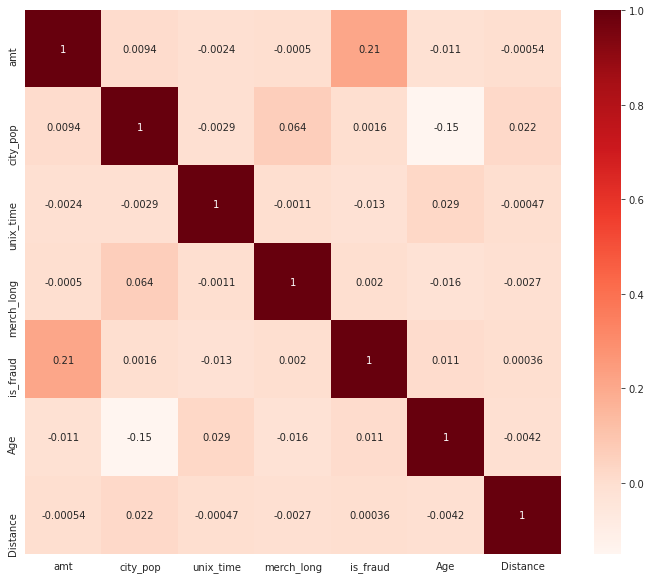

In [49]:
corrmat = Fraud.corr()
plt.figure(figsize=(12,10))
sns.heatmap(Fraud[corrmat.index].corr(),annot=True,cmap="Reds")

In [50]:
#Dealing With Categorical Variables
df_categorical = Fraud.select_dtypes(include=['object'])
df_categorical.columns

Index(['merchant', 'category', 'gender', 'street', 'city', 'state', 'job',
       'Weekday'],
      dtype='object')

In [51]:
# Creating dummies for categorical variables
df_dummies = pd.get_dummies(df_categorical, sparse=True,drop_first=True)
df_dummies.head()

,merchant_fraud_Abbott-Steuber,merchant_fraud_Abernathy and Sons,merchant_fraud_Abshire PLC,"merchant_fraud_Adams, Kovacek and Kuhlman",merchant_fraud_Adams-Barrows,"merchant_fraud_Altenwerth, Cartwright and Koss",merchant_fraud_Altenwerth-Kilback,merchant_fraud_Ankunding LLC,merchant_fraud_Ankunding-Carroll,"merchant_fraud_Armstrong, Walter and Gottlieb",merchant_fraud_Auer LLC,merchant_fraud_Auer-Mosciski,merchant_fraud_Auer-West,merchant_fraud_Bahringer Group,"merchant_fraud_Bahringer, Bergnaum and Quitzon","merchant_fraud_Bahringer, Osinski and Block","merchant_fraud_Bahringer, Schoen and Corkery",merchant_fraud_Bahringer-Larson,merchant_fraud_Bahringer-Streich,merchant_fraud_Bailey-Morar,merchant_fraud_Balistreri-Nader,merchant_fraud_Barrows PLC,merchant_fraud_Bartoletti and Sons,merchant_fraud_Bartoletti-Wunsch,merchant_fraud_Barton Inc,merchant_fraud_Barton LLC,merchant_fraud_Bashirian Group,merchant_fraud_Bauch-Blanda,merchant_fraud_Bauch-Raynor,merchant_fraud_Baumbach Ltd,"merchant_fraud_Baumbach, Feeney and Morar","merchant_fraud_Baumbach, Hodkiewicz and Walsh","merchant_fraud_Baumbach, Strosin and Nicolas",merchant_fraud_Bechtelar-Rippin,"merchant_fraud_Becker, Harris and Harvey",merchant_fraud_Bednar Group,merchant_fraud_Bednar Inc,merchant_fraud_Bednar PLC,merchant_fraud_Beer-Jast,merchant_fraud_Beier LLC,merchant_fraud_Beier and Sons,merchant_fraud_Beier-Hyatt,merchant_fraud_Berge LLC,"merchant_fraud_Berge, Kautzer and Harris",merchant_fraud_Berge-Hills,merchant_fraud_Berge-Ullrich,merchant_fraud_Bernhard Inc,"merchant_fraud_Bernhard, Grant and Langworth",merchant_fraud_Bernhard-Lesch,merchant_fraud_Bernier and Sons,"merchant_fraud_Bernier, Streich and Jewess","merchant_fraud_Bernier, Volkman and Hoeger","merchant_fraud_Bins, Balistreri and Beatty",merchant_fraud_Bins-Howell,merchant_fraud_Bins-Rice,merchant_fraud_Bins-Tillman,merchant_fraud_Block Group,merchant_fraud_Block-Hauck,merchant_fraud_Block-Parisian,merchant_fraud_Bode-Rempel,merchant_fraud_Bode-Schuster,"merchant_fraud_Boehm, Block and Jakubowski","merchant_fraud_Boehm, Predovic and Reinger",merchant_fraud_Bogisich Inc,merchant_fraud_Bogisich-Homenick,merchant_fraud_Bogisich-Weimann,merchant_fraud_Botsford Ltd,merchant_fraud_Botsford PLC,merchant_fraud_Botsford and Sons,merchant_fraud_Boyer PLC,merchant_fraud_Boyer-Haley,merchant_fraud_Boyer-Reichert,merchant_fraud_Bradtke PLC,"merchant_fraud_Bradtke, Torp and Bahringer",merchant_fraud_Breitenberg LLC,merchant_fraud_Breitenberg-Hermiston,merchant_fraud_Brekke and Sons,merchant_fraud_Brown Inc,merchant_fraud_Brown PLC,"merchant_fraud_Brown, Homenick and Lesch",merchant_fraud_Brown-Greenholt,merchant_fraud_Bruen-Yost,merchant_fraud_Buckridge PLC,merchant_fraud_Carroll PLC,merchant_fraud_Cartwright PLC,merchant_fraud_Cartwright-Harris,"merchant_fraud_Casper, Hand and Zulauf",merchant_fraud_Cassin-Harvey,merchant_fraud_Champlin and Sons,"merchant_fraud_Champlin, Rolfson and Connelly",merchant_fraud_Champlin-Casper,"merchant_fraud_Christiansen, Goyette and Schamberger",merchant_fraud_Christiansen-Gusikowski,merchant_fraud_Cole PLC,"merchant_fraud_Cole, Hills and Jewess",merchant_fraud_Collier Inc,merchant_fraud_Collier LLC,merchant_fraud_Connelly PLC,"merchant_fraud_Connelly, Reichert and Fritsch",merchant_fraud_Connelly-Carter,merchant_fraud_Conroy Ltd,"merchant_fraud_Conroy, Balistreri and Gorczany",merchant_fraud_Conroy-Cruickshank,merchant_fraud_Conroy-Emard,merchant_fraud_Cormier LLC,"merchant_fraud_Cormier, Stracke and Thiel",merchant_fraud_Corwin-Collins,merchant_fraud_Corwin-Gorczany,merchant_fraud_Corwin-Romaguera,"merchant_fraud_Cremin, Hamill and Reichel","merchant_fraud_Crist, Jakubowski and Littel",merchant_fraud_Crona and Sons,"merchant_fraud_Cronin, Kshlerin and Weber",merchant_fraud_Crooks and Sons,merchant_fraud_Cruickshank-Mills,merchant_fraud_Cummerata-Hilpert,merchant_fraud_Cummerata-Jones,merchant_fraud_Cummings Group,merchant_fraud_Cummings LLC,merchant_fraud_Dach-Borer,merchant_fraud_

In [52]:
# Concating the dummy variables first 
Fraud = pd.concat([Fraud, df_dummies],axis=1)
# Then dropping the categorical variables as they are already dummy-encoded.
Fraud.drop(df_categorical,axis=1,inplace=True)
Fraud.head()

,amt,city_pop,unix_time,merch_long,is_fraud,Age,Distance,merchant_fraud_Abbott-Steuber,merchant_fraud_Abernathy and Sons,merchant_fraud_Abshire PLC,"merchant_fraud_Adams, Kovacek and Kuhlman",merchant_fraud_Adams-Barrows,"merchant_fraud_Altenwerth, Cartwright and Koss",merchant_fraud_Altenwerth-Kilback,merchant_fraud_Ankunding LLC,merchant_fraud_Ankunding-Carroll,"merchant_fraud_Armstrong, Walter and Gottlieb",merchant_fraud_Auer LLC,merchant_fraud_Auer-Mosciski,merchant_fraud_Auer-West,merchant_fraud_Bahringer Group,"merchant_fraud_Bahringer, Bergnaum and Quitzon","merchant_fraud_Bahringer, Osinski and Block","merchant_fraud_Bahringer, Schoen and Corkery",merchant_fraud_Bahringer-Larson,merchant_fraud_Bahringer-Streich,merchant_fraud_Bailey-Morar,merchant_fraud_Balistreri-Nader,merchant_fraud_Barrows PLC,merchant_fraud_Bartoletti and Sons,merchant_fraud_Bartoletti-Wunsch,merchant_fraud_Barton Inc,merchant_fraud_Barton LLC,merchant_fraud_Bashirian Group,merchant_fraud_Bauch-Blanda,merchant_fraud_Bauch-Raynor,merchant_fraud_Baumbach Ltd,"merchant_fraud_Baumbach, Feeney and Morar","merchant_fraud_Baumbach, Hodkiewicz and Walsh","merchant_fraud_Baumbach, Strosin and Nicolas",merchant_fraud_Bechtelar-Rippin,"merchant_fraud_Becker, Harris and Harvey",merchant_fraud_Bednar Group,merchant_fraud_Bednar Inc,merchant_fraud_Bednar PLC,merchant_fraud_Beer-Jast,merchant_fraud_Beier LLC,merchant_fraud_Beier and Sons,merchant_fraud_Beier-Hyatt,merchant_fraud_Berge LLC,"merchant_fraud_Berge, Kautzer and Harris",merchant_fraud_Berge-Hills,merchant_fraud_Berge-Ullrich,merchant_fraud_Bernhard Inc,"merchant_fraud_Bernhard, Grant and Langworth",merchant_fraud_Bernhard-Lesch,merchant_fraud_Bernier and Sons,"merchant_fraud_Bernier, Streich and Jewess","merchant_fraud_Bernier, Volkman and Hoeger","merchant_fraud_Bins, Balistreri and Beatty",merchant_fraud_Bins-Howell,merchant_fraud_Bins-Rice,merchant_fraud_Bins-Tillman,merchant_fraud_Block Group,merchant_fraud_Block-Hauck,merchant_fraud_Block-Parisian,merchant_fraud_Bode-Rempel,merchant_fraud_Bode-Schuster,"merchant_fraud_Boehm, Block and Jakubowski","merchant_fraud_Boehm, Predovic and Reinger",merchant_fraud_Bogisich Inc,merchant_fraud_Bogisich-Homenick,merchant_fraud_Bogisich-Weimann,merchant_fraud_Botsford Ltd,merchant_fraud_Botsford PLC,merchant_fraud_Botsford and Sons,merchant_fraud_Boyer PLC,merchant_fraud_Boyer-Haley,merchant_fraud_Boyer-Reichert,merchant_fraud_Bradtke PLC,"merchant_fraud_Bradtke, Torp and Bahringer",merchant_fraud_Breitenberg LLC,merchant_fraud_Breitenberg-Hermiston,merchant_fraud_Brekke and Sons,merchant_fraud_Brown Inc,merchant_fraud_Brown PLC,"merchant_fraud_Brown, Homenick and Lesch",merchant_fraud_Brown-Greenholt,merchant_fraud_Bruen-Yost,merchant_fraud_Buckridge PLC,merchant_fraud_Carroll PLC,merchant_fraud_Cartwright PLC,merchant_fraud_Cartwright-Harris,"merchant_fraud_Casper, Hand and Zulauf",merchant_fraud_Cassin-Harvey,merchant_fraud_Champlin and Sons,"merchant_fraud_Champlin, Rolfson and Connelly",merchant_fraud_Champlin-Casper,"merchant_fraud_Christiansen, Goyette and Schamberger",merchant_fraud_Christiansen-Gusikowski,merchant_fraud_Cole PLC,"merchant_fraud_Cole, Hills and Jewess",merchant_fraud_Collier Inc,merchant_fraud_Collier LLC,merchant_fraud_Connelly PLC,"merchant_fraud_Connelly, Reichert and Fritsch",merchant_fraud_Connelly-Carter,merchant_fraud_Conroy Ltd,"merchant_fraud_Conroy, Balistreri and Gorczany",merchant_fraud_Conroy-Cruickshank,merchant_fraud_Conroy-Emard,merchant_fraud_Cormier LLC,"merchant_fraud_Cormier, Stracke and Thiel",merchant_fraud_Corwin-Collins,merchant_fraud_Corwin-Gorczany,merchant_fraud_Corwin-Romaguera,"merchant_fraud_Cremin, Hamill and Reichel","merchant_fraud_Crist, Jakubowski and Littel",merchant_fraud_Crona and Sons,"merchant_fraud_Cronin, Kshlerin and Weber",merchant_fraud_Crooks and Sons,merchant_fraud_Cruickshank-Mills,merchant_fraud_Cummerata-Hilpert,merchant_fraud_Cummerata-Jones,merchant_fraud_Cummings Group,merchant_frau

In [53]:
#As this dataset is highly imbalance we have to balance this by under-sampling
count_fraud = Fraud[Fraud['is_fraud'] == 1]['amt'].count()
class_fraud = Fraud[Fraud['is_fraud'] == 1]
class_nonfraud = Fraud[Fraud['is_fraud'] == 0]

In [54]:
#underSampling
fraud_undersample = class_nonfraud.sample(count_fraud, replace=True)
undersampled = pd.concat([class_fraud, fraud_undersample], axis=0)

print('UnderSampling:')
print(undersampled['is_fraud'].value_counts())

UnderSampling:
1    9651
0    9651
Name: is_fraud, dtype: int64


In [55]:
# Putting feature variable to X
X = undersampled.drop(['is_fraud'], axis=1)
y = undersampled['is_fraud']
X.head()

,amt,city_pop,unix_time,merch_long,Age,Distance,merchant_fraud_Abbott-Steuber,merchant_fraud_Abernathy and Sons,merchant_fraud_Abshire PLC,"merchant_fraud_Adams, Kovacek and Kuhlman",merchant_fraud_Adams-Barrows,"merchant_fraud_Altenwerth, Cartwright and Koss",merchant_fraud_Altenwerth-Kilback,merchant_fraud_Ankunding LLC,merchant_fraud_Ankunding-Carroll,"merchant_fraud_Armstrong, Walter and Gottlieb",merchant_fraud_Auer LLC,merchant_fraud_Auer-Mosciski,merchant_fraud_Auer-West,merchant_fraud_Bahringer Group,"merchant_fraud_Bahringer, Bergnaum and Quitzon","merchant_fraud_Bahringer, Osinski and Block","merchant_fraud_Bahringer, Schoen and Corkery",merchant_fraud_Bahringer-Larson,merchant_fraud_Bahringer-Streich,merchant_fraud_Bailey-Morar,merchant_fraud_Balistreri-Nader,merchant_fraud_Barrows PLC,merchant_fraud_Bartoletti and Sons,merchant_fraud_Bartoletti-Wunsch,merchant_fraud_Barton Inc,merchant_fraud_Barton LLC,merchant_fraud_Bashirian Group,merchant_fraud_Bauch-Blanda,merchant_fraud_Bauch-Raynor,merchant_fraud_Baumbach Ltd,"merchant_fraud_Baumbach, Feeney and Morar","merchant_fraud_Baumbach, Hodkiewicz and Walsh","merchant_fraud_Baumbach, Strosin and Nicolas",merchant_fraud_Bechtelar-Rippin,"merchant_fraud_Becker, Harris and Harvey",merchant_fraud_Bednar Group,merchant_fraud_Bednar Inc,merchant_fraud_Bednar PLC,merchant_fraud_Beer-Jast,merchant_fraud_Beier LLC,merchant_fraud_Beier and Sons,merchant_fraud_Beier-Hyatt,merchant_fraud_Berge LLC,"merchant_fraud_Berge, Kautzer and Harris",merchant_fraud_Berge-Hills,merchant_fraud_Berge-Ullrich,merchant_fraud_Bernhard Inc,"merchant_fraud_Bernhard, Grant and Langworth",merchant_fraud_Bernhard-Lesch,merchant_fraud_Bernier and Sons,"merchant_fraud_Bernier, Streich and Jewess","merchant_fraud_Bernier, Volkman and Hoeger","merchant_fraud_Bins, Balistreri and Beatty",merchant_fraud_Bins-Howell,merchant_fraud_Bins-Rice,merchant_fraud_Bins-Tillman,merchant_fraud_Block Group,merchant_fraud_Block-Hauck,merchant_fraud_Block-Parisian,merchant_fraud_Bode-Rempel,merchant_fraud_Bode-Schuster,"merchant_fraud_Boehm, Block and Jakubowski","merchant_fraud_Boehm, Predovic and Reinger",merchant_fraud_Bogisich Inc,merchant_fraud_Bogisich-Homenick,merchant_fraud_Bogisich-Weimann,merchant_fraud_Botsford Ltd,merchant_fraud_Botsford PLC,merchant_fraud_Botsford and Sons,merchant_fraud_Boyer PLC,merchant_fraud_Boyer-Haley,merchant_fraud_Boyer-Reichert,merchant_fraud_Bradtke PLC,"merchant_fraud_Bradtke, Torp and Bahringer",merchant_fraud_Breitenberg LLC,merchant_fraud_Breitenberg-Hermiston,merchant_fraud_Brekke and Sons,merchant_fraud_Brown Inc,merchant_fraud_Brown PLC,"merchant_fraud_Brown, Homenick and Lesch",merchant_fraud_Brown-Greenholt,merchant_fraud_Bruen-Yost,merchant_fraud_Buckridge PLC,merchant_fraud_Carroll PLC,merchant_fraud_Cartwright PLC,merchant_fraud_Cartwright-Harris,"merchant_fraud_Casper, Hand and Zulauf",merchant_fraud_Cassin-Harvey,merchant_fraud_Champlin and Sons,"merchant_fraud_Champlin, Rolfson and Connelly",merchant_fraud_Champlin-Casper,"merchant_fraud_Christiansen, Goyette and Schamberger",merchant_fraud_Christiansen-Gusikowski,merchant_fraud_Cole PLC,"merchant_fraud_Cole, Hills and Jewess",merchant_fraud_Collier Inc,merchant_fraud_Collier LLC,merchant_fraud_Connelly PLC,"merchant_fraud_Connelly, Reichert and Fritsch",merchant_fraud_Connelly-Carter,merchant_fraud_Conroy Ltd,"merchant_fraud_Conroy, Balistreri and Gorczany",merchant_fraud_Conroy-Cruickshank,merchant_fraud_Conroy-Emard,merchant_fraud_Cormier LLC,"merchant_fraud_Cormier, Stracke and Thiel",merchant_fraud_Corwin-Collins,merchant_fraud_Corwin-Gorczany,merchant_fraud_Corwin-Romaguera,"merchant_fraud_Cremin, Hamill and Reichel","merchant_fraud_Crist, Jakubowski and Littel",merchant_fraud_Crona and Sons,"merchant_fraud_Cronin, Kshlerin and Weber",merchant_fraud_Crooks and Sons,merchant_fraud_Cruickshank-Mills,merchant_fraud_Cummerata-Hilpert,merchant_fraud_Cummerata-Jones,merchant_fraud_Cummings Group,merchant_fraud_Cumming

In [56]:
#Importing Library
from sklearn import model_selection

Train/Test Data Splitting

In [57]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, random_state=0)

In [58]:
X_train.shape

(14476, 3167)

In [59]:
X_test.shape

(4826, 3167)

In [60]:
num_cv_splits = 3
skf = model_selection.StratifiedKFold(n_splits=num_cv_splits, shuffle=True, random_state=0)

**Model Building**

In [61]:
# Logistic Regression
from sklearn import metrics
from sklearn import linear_model

num_C = [0.001, 0.01, 0.1, 1.0]
auc = np.zeros((len(num_C), num_cv_splits))
cv_num = 0
for train_index, test_index in skf.split(X_train, y_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    for C_id, C_val in enumerate(num_C):
        clf = linear_model.LogisticRegression(C=C_val, random_state=0, solver='lbfgs', max_iter=1000, n_jobs=-1)
        clf.fit(X_train_cv, y_train_cv)
        auc[C_id, cv_num] = metrics.roc_auc_score(y_true = y_test_cv, y_score = clf.predict_proba(X_test_cv)[:,1])
        print('C_val =', C_val, '; auc =', auc[C_id, cv_num], '; cv_num =', cv_num)
    cv_num += 1
mean_auc = np.mean(auc, axis=1)
print('Best C:', num_C[np.argmax(mean_auc)])
print('Best auc corresponding to Best C:', mean_auc[np.argmax(mean_auc)])
# Best C: 0.01
# Best auc corresponding to Best C: 0.55

C_val = 0.001 ; auc = 0.5524973598423651 ; cv_num = 0
C_val = 0.01 ; auc = 0.5524973598423651 ; cv_num = 0
C_val = 0.1 ; auc = 0.5524973598423651 ; cv_num = 0
C_val = 1.0 ; auc = 0.5524973598423651 ; cv_num = 0
C_val = 0.001 ; auc = 0.548181354589121 ; cv_num = 1
C_val = 0.01 ; auc = 0.548181354589121 ; cv_num = 1
C_val = 0.1 ; auc = 0.548181354589121 ; cv_num = 1
C_val = 1.0 ; auc = 0.548181354589121 ; cv_num = 1
C_val = 0.001 ; auc = 0.5416411518866504 ; cv_num = 2
C_val = 0.01 ; auc = 0.5416411518866504 ; cv_num = 2
C_val = 0.1 ; auc = 0.5416411518866504 ; cv_num = 2
C_val = 1.0 ; auc = 0.5416411518866504 ; cv_num = 2
Best C: 0.001
Best auc corresponding to Best C: 0.5474399554393788


In [62]:
# Decision Tree

from sklearn import tree

num_depth = range(2, 7)
num_min_samples_leaf = [30,50,100]
num_min_samples_split = [2,31]
auc = np.zeros((len(num_depth)*len(num_min_samples_leaf)*len(num_min_samples_split), num_cv_splits))
cv_num = 0
for train_index, test_index in skf.split(X_train, y_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    for depth_id, depth in enumerate(num_depth):
        for min_samples_leaf_id, min_samples_leaf in enumerate(num_min_samples_leaf):
            for min_samples_split_id, min_samples_split in enumerate(num_min_samples_split):
                clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth,
                        min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, random_state=0)
                clf.fit(X_train_cv, y_train_cv)
                auc_id = depth_id*len(num_min_samples_leaf)*len(num_min_samples_split)+\
                            min_samples_leaf_id*len(num_min_samples_split)+min_samples_split_id
                auc[auc_id, cv_num] = metrics.roc_auc_score(y_true = y_test_cv, y_score = clf.predict_proba(X_test_cv)[:,1])
                print('depth =', depth, '; min_samples_leaf =', min_samples_leaf, '; min_samples_split =',
                      min_samples_split, '; auc =', auc[auc_id, cv_num], '; cv_num =', cv_num)
    cv_num += 1
mean_auc = np.mean(auc, axis=1)
depth_id = np.argmax(mean_auc)//(len(num_min_samples_leaf)*len(num_min_samples_split))
min_samples_leaf_id = (np.argmax(mean_auc) - depth_id*len(num_min_samples_leaf)*len(num_min_samples_split))//len(
                       num_min_samples_split)
min_samples_split_id = (np.argmax(mean_auc) - depth_id*len(num_min_samples_leaf)*len(num_min_samples_split))%len(
                       num_min_samples_split)
print('Best depth:', num_depth[depth_id])
print('Best min_samples_leaf:', num_min_samples_leaf[min_samples_leaf_id])
print('Best min_samples_split:', num_min_samples_leaf[min_samples_split_id])
print('Best auc corresponding to Best depth, min_samples_leaf & min_samples_split :', mean_auc[np.argmax(mean_auc)])
# Best depth: 5
# Best min_samples_leaf: 100
# Best min_samples_split: 30
# Best auc corresponding to Best depth, min_samples_leaf & min_samples_split : 0.982

depth = 2 ; min_samples_leaf = 30 ; min_samples_split = 2 ; auc = 0.9265421328626591 ; cv_num = 0
depth = 2 ; min_samples_leaf = 30 ; min_samples_split = 31 ; auc = 0.9265421328626591 ; cv_num = 0
depth = 2 ; min_samples_leaf = 50 ; min_samples_split = 2 ; auc = 0.9265421328626591 ; cv_num = 0
depth = 2 ; min_samples_leaf = 50 ; min_samples_split = 31 ; auc = 0.9265421328626591 ; cv_num = 0
depth = 2 ; min_samples_leaf = 100 ; min_samples_split = 2 ; auc = 0.9265421328626591 ; cv_num = 0
depth = 2 ; min_samples_leaf = 100 ; min_samples_split = 31 ; auc = 0.9265421328626591 ; cv_num = 0
depth = 3 ; min_samples_leaf = 30 ; min_samples_split = 2 ; auc = 0.9519658762309213 ; cv_num = 0
depth = 3 ; min_samples_leaf = 30 ; min_samples_split = 31 ; auc = 0.9519658762309213 ; cv_num = 0
depth = 3 ; min_samples_leaf = 50 ; min_samples_split = 2 ; auc = 0.9519378817150985 ; cv_num = 0
depth = 3 ; min_samples_leaf = 50 ; min_samples_split = 31 ; auc = 0.9519378817150985 ; cv_num = 0
depth = 3 ; m

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(" DT Test Results")
DT_pred_test = clf.predict(X_test)

print(confusion_matrix(y_test, DT_pred_test))
print(classification_report(y_test, DT_pred_test))

 DT Test Results
[[2258  155]
 [ 234 2179]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2413
           1       0.93      0.90      0.92      2413

    accuracy                           0.92      4826
   macro avg       0.92      0.92      0.92      4826
weighted avg       0.92      0.92      0.92      4826



In [64]:
# Random Forest

from sklearn import ensemble

initial_trees = 801
num_trees = 899
tree_increment = 1
trees = range(initial_trees, num_trees+1, tree_increment)
auc = np.zeros((len(trees), num_cv_splits))
cv_num = 0
for train_index, test_index in skf.split(X_train, y_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    clf = ensemble.RandomForestClassifier(criterion='entropy', min_samples_leaf=30, warm_start=True, n_jobs=-1,
                                          random_state=0)
    for tree_id, tree in enumerate(trees):
        clf.set_params(n_estimators=tree)
        clf.fit(X_train_cv, y_train_cv)
        auc[tree_id, cv_num] = metrics.roc_auc_score(y_true = y_test_cv, y_score = clf.predict_proba(X_test_cv)[:,1])
        print('num_trees =', tree, '; auc =', auc[tree_id, cv_num], '; cv_num =', cv_num)
    cv_num += 1
mean_auc = np.mean(auc, axis=1)
print('Best num_trees:', trees[np.argmax(mean_auc)])
print('Best auc corresponding to Best num_trees :', mean_auc[np.argmax(mean_auc)])
# Best num_trees: 860

num_trees = 801 ; auc = 0.8659717042425774 ; cv_num = 0
num_trees = 802 ; auc = 0.8659701585331148 ; cv_num = 0
num_trees = 803 ; auc = 0.865976684861957 ; cv_num = 0
num_trees = 804 ; auc = 0.8659854438822451 ; cv_num = 0
num_trees = 805 ; auc = 0.8659845851547658 ; cv_num = 0
num_trees = 806 ; auc = 0.8659694715511315 ; cv_num = 0
num_trees = 807 ; auc = 0.8659694715511315 ; cv_num = 0
num_trees = 808 ; auc = 0.8659792610443946 ; cv_num = 0
num_trees = 809 ; auc = 0.8660280367652148 ; cv_num = 0
num_trees = 810 ; auc = 0.8659638039497686 ; cv_num = 0
num_trees = 811 ; auc = 0.8659638039497686 ; cv_num = 0
num_trees = 812 ; auc = 0.8659627734767934 ; cv_num = 0
num_trees = 813 ; auc = 0.8659402748168377 ; cv_num = 0
num_trees = 814 ; auc = 0.8659085019001063 ; cv_num = 0
num_trees = 815 ; auc = 0.8658880641861006 ; cv_num = 0
num_trees = 816 ; auc = 0.8658839422942004 ; cv_num = 0
num_trees = 817 ; auc = 0.8658664242536241 ; cv_num = 0
num_trees = 818 ; auc = 0.8657510112804159 ; cv_n

In [65]:
print("RF Test Results")
RF_pred_test = clf.predict(X_test)

print(confusion_matrix(y_test, RF_pred_test))
print(classification_report(y_test, RF_pred_test))

RF Test Results
[[2329   84]
 [ 649 1764]]
              precision    recall  f1-score   support

           0       0.78      0.97      0.86      2413
           1       0.95      0.73      0.83      2413

    accuracy                           0.85      4826
   macro avg       0.87      0.85      0.85      4826
weighted avg       0.87      0.85      0.85      4826



**Cost-Benefit Analysis**

In [66]:
Fraud_transactions = Fraud_time[Fraud_time['is_fraud']==1]

Timeline = Fraud_transactions.groupby(Fraud_transactions['year_month'])[['trans_num','cc_num','amt']].nunique().reset_index()
Timeline.columns = ['year_month','num_of_fraud_transactions','customers','Amount']
Timeline

,year_month,num_of_fraud_transactions,customers,Amount
0,2019-01,506,50,502
1,2019-02,517,53,515
2,2019-03,494,49,490
3,2019-04,376,41,375
4,2019-05,408,42,406
5,2019-06,354,35,353
6,2019-07,331,36,330
7,2019-08,382,39,381
8,2019-09,418,44,415
9,2019-10,454,50,453


In [67]:
#Average number of fraudulent transaction per month
number_transaction =Timeline['num_of_fraud_transactions'].mean()
number_transaction

402.125

In [68]:
pd.concat(
[Fraud_time['amt'].describe(percentiles = [0.5,0.95,0.999])\
.reset_index().rename(columns={'index': 'Row Type', 'amt':'Overall Amt Distribution'}),
Fraud_time.loc[Fraud_time['is_fraud']==0,['amt']].describe(percentiles = [0.5,0.95,0.999])\
.reset_index(drop = 1).rename(columns={'amt':'Non Fraud Amt Distribution'}),
Fraud_time.loc[Fraud_time['is_fraud']==1,['amt']].describe(percentiles = [0.5,0.95,0.999])\
.reset_index(drop = 1).rename(columns={'amt':'Fraud Amt Distribution'})],
axis=1
)
#Average amount per fraud transaction is $530.66

,Row Type,Overall Amt Distribution,Non Fraud Amt Distribution,Fraud Amt Distribution
0,count,1.852394e+06,1.842743e+06,9651.000000
1,mean,7.006357e+01,6.765128e+01,530.661412
2,std,1.592540e+02,1.535481e+02,391.028873
3,min,1.000000e+00,1.000000e+00,1.060000
4,50%,4.745000e+01,4.724000e+01,390.000000
5,95%,1.953400e+02,1.895900e+02,1084.090000
6,99.9%,1.517241e+03,1.519623e+03,1293.127000
7,max,2.894890e+04,2.894890e+04,1376.040000


In [69]:
Complete_timeline = Fraud_time.groupby(Fraud_time['year_month'])[['trans_num','cc_num']].nunique().reset_index()
Complete_timeline.columns = ['year_month','num_of_transactions','customers']
Complete_timeline

,year_month,num_of_transactions,customers
0,2019-01,52525,913
1,2019-02,49866,918
2,2019-03,70939,916
3,2019-04,68078,913
4,2019-05,72532,910
5,2019-06,86064,908
6,2019-07,86596,910
7,2019-08,87359,911
8,2019-09,70652,913
9,2019-10,68758,912


In [70]:
#Average number of transactions per month
Complete_timeline['num_of_transactions'].mean()

77183.08333333333